# Dynamics 365 Business Central Trouble Shooting Guide (TSG) - Performance analysis (overview)

This notebook contains Kusto queries that can help getting to the root cause of a performance issue for an environment. Each section in the notebook contains links to the performance tuning guide on docs [aka.ms/bcperformance](aka.ms/bcperformance),  links to the documentation of relevant telemetry in [aka.ms/bctelemetry](aka.ms/bctelemetry), as well as Kusto queries that help dive into a specific area (sessions, web service requests, database calls, reports, and page load times).

NB! Some of the signal used in this notebook is only available in newer versions of Business Central, so check the version of your environment if some sections do not return any data. The signal documentation states in which version a given signal was introduced.

Set Input Parameters

In [ ]:
AppInsights = ''
AppKey = ''
AADTenantID = ''
ExtensionID = ''
startDate = '2021-01-12'
endDate = '2021-01-30'

## 1\. Get setup: Load up Python libraries and connect to Application Insights

First you need to set the notebook Kernel to Python3, load the KQLmagic module (did you install it?) and connect to your Application Insights resource (get appid and appkey from the API access page in the Application Insights portal)


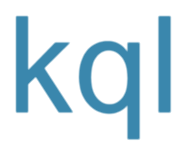

In [1]:
# load the KQLmagic module
%reload_ext Kqlmagic

In [4]:
# Connect to the Application Insights API
#%kql appinsights://appid='<add app id from the Application Insights portal>';appkey='<add API key from the Application Insights portal>'
%kql appinsights://appid=AppInsights;appkey=AppKey;alias='D365BC'

In [ ]:
%kql --config "short_errors=False"

## 2\. Define filters

This workbook is designed for troubleshooting a single environment. Please provide values for aadTenantId and environmentName (or use a config file).

In [2]:
# Add values for AAD tenant id, environment name, and date range.
# It is possible to leave the value for environment name blank (if you want to analyze across all values of the parameter)

# You can either use configuration file (INI file format) or set filters directly. 

# If you specify a config file, then variables set here takes precedence over manually set filter variables
# config file name and directory (full path)
configFile = "c:/tmp/notebook.ini1"


# Add AAD tenant id and environment name here
aadTenantId = AADTenantID
#aadTenantId = "MyaaDtenantId"
environmentName = ""
extensionId = ExtensionID

# date filters for the analysis
# use YYYY-MM-DD format for the dates (ISO 8601)
startDate = startDate
endDate = endDate




# Do not edit this code section
import configparser
config = configparser.ConfigParser()

config.read(configFile)

if bool(config.defaults()):
    if config.has_option('DEFAULT', 'aadTenantId'):
        aadTenantId = config['DEFAULT']['aadTenantId']
    if config.has_option('DEFAULT', 'environmentName'):
        environmentName = config['DEFAULT']['environmentName']
    if config.has_option('DEFAULT', 'extensionId'):
        extensionId = config['DEFAULT']['extensionId']
    if config.has_option('DEFAULT', 'startDate'):    
        startDate = config['DEFAULT']['startDate']
    if config.has_option('DEFAULT', 'endDate'):
        endDate = config['DEFAULT']['endDate']

print("Using these parameters for the analysis:")
print("----------------------------------------")
print("aadTenantId         " + aadTenantId)
print("environmentName     " + environmentName)
print("startDate           " + startDate)
print("endDate             " + endDate)

Using these parameters for the analysis:
----------------------------------------
aadTenantId         67e44043-eac5-4b8d-94f9-05d3d9094020
environmentName     
startDate           2021-01-12
endDate             2021-01-30


# Analyze performance
Now you can run Kusto queries to look for possible root causes for performance issues.

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries

## Sessions

Performance tuning guide: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-online#telemetry

Session telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-authorization-trace#authorization-succeeded-open-company

KQL samples: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Authorization.kql

In [6]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0004'
| extend clientType = tostring( customDimensions.clientType )
| summarize request_count=count() by clientType, bin(timestamp, 1d)
| render timechart title= 'Number of sessions by client type'

[{'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 28, 0, 0, tzinfo=tzutc()), 'request_count': 605},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 29, 0, 0, tzinfo=tzutc()), 'request_count': 605},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 27, 0, 0, tzinfo=tzutc()), 'request_count': 618},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 23, 0, 0, tzinfo=tzutc()), 'request_count': 607},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 22, 0, 0, tzinfo=tzutc()), 'request_count': 339},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 25, 0, 0, tzinfo=tzutc()), 'request_count': 630},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 24, 0, 0, tzinfo=tzutc()), 'request_count': 604},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 26, 0, 0, tzinfo=tzutc()), 'request_count': 618},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 1, 26, 0, 0, tzinfo=tzutc()), 'request_count': 7},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 30, 0, 0, tzinfo=tzutc()), 'request_count': 376},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 1, 27, 0, 0, tzinfo=tzutc()), 'request_count': 2},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 1, 26, 0, 0, tzinfo=tzutc()), 'request_count': 1},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 1, 25, 0, 0, tzinfo=tzutc()), 'request_count': 2},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 1, 25, 0, 0, tzinfo=tzutc()), 'request_count': 4},
 {'clientType': 'ChildSession', 'timestamp': datetime.datetime(2021, 1, 22, 0, 0, tzinfo=tzutc()), 'request_count': 9},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 1, 22, 0, 0, tzinfo=tzutc()), 'request_count': 2}]

In [7]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0004'
| extend clientType = tostring( customDimensions.clientType )
       , executionTimeInSec = toreal(totimespan(customDimensions.serverExecutionTime))/10000000
| summarize _count=count() by executionTimeInSeconds = bin(executionTimeInSec, 1), clientType
| extend log_count = log10( _count )
| order by clientType, executionTimeInSeconds asc
| render columnchart with  (ycolumns = log_count, series = clientType, title= 'Execution time (in seconds) of session login time by client type', ytitle = 'log(count)') 

[{'executionTimeInSeconds': 0, 'clientType': 'WebClient', '_count': 4, 'log_count': 0.6020599913279624},
 {'executionTimeInSeconds': 1, 'clientType': 'WebClient', '_count': 2, 'log_count': 0.3010299956639812},
 {'executionTimeInSeconds': 5, 'clientType': 'WebClient', '_count': 1, 'log_count': 0},
 {'executionTimeInSeconds': 0, 'clientType': 'ChildSession', '_count': 20, 'log_count': 1.3010299956639813},
 {'executionTimeInSeconds': 0, 'clientType': 'Background', '_count': 4996, 'log_count': 3.6986224297020978},
 {'executionTimeInSeconds': 2, 'clientType': 'Background', '_count': 1, 'log_count': 0},
 {'executionTimeInSeconds': 7, 'clientType': 'Background', '_count': 1, 'log_count': 0},
 {'executionTimeInSeconds': 8, 'clientType': 'Background', '_count': 1, 'log_count': 0},
 {'executionTimeInSeconds': 9, 'clientType': 'Background', '_count': 2, 'log_count': 0.3010299956639812},
 {'executionTimeInSeconds': 10, 'clientType': 'Background', '_count': 1, 'log_count': 0}]

## Web service requests (incoming)

Performance tuning guide: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services)

Web service telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace)

KQL samples: [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/WebServiceCalls.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/WebServiceCalls.kql)

In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
| extend category = tostring( customDimensions.category )
| summarize request_count=count() by category, bin(timestamp, 1d)
| render timechart title= 'Number of web service requests by category'

[{'category': 'ODataV4', 'timestamp': datetime.datetime(2021, 1, 22, 0, 0, tzinfo=tzutc()), 'request_count': 1}]

In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
| extend category = tostring( customDimensions.category )
       , executionTimeInMS = toreal(totimespan(customDimensions.serverExecutionTime))/10000 //the datatype for executionTime is timespan 
| summarize count=count() by executionTime_ms = bin(executionTimeInMS, 100), category
| order by category, executionTime_ms asc
| render columnchart with  (ycolumns = count, series = category, title= 'Execution time (in milliseconds) of web service requests by category' ) 


[{'executionTime_ms': 12700, 'category': 'ODataV4', 'count': 1}]

## (Outgoing) web service requests overview 

Performance tuning guide: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#web-service-client-performance](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services)

Outgoing Web service telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-outgoing-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-outgoing-trace) 

KQL sample: [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/OutGoingWebServiceCalls.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/OutGoingWebServiceCalls.kql)

Explanation of different HTTP status codes: [https://en.wikipedia.org/wiki/List_of_HTTP_status_codes](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)

In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)    
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0019'
| extend alObjectId = toint(customDimensions.alObjectId)    
| extend httpStatusCode = tostring( customDimensions.httpReturnCode )
| summarize request_count=count() by httpStatusCode, bin(timestamp, 1d)
| order by httpStatusCode asc
| render timechart title= 'Number of outgoing web service requests by HTTP status code'

[{'httpStatusCode': '200', 'timestamp': datetime.datetime(2021, 1, 22, 0, 0, tzinfo=tzutc()), 'request_count': 1}]

In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)        
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0019'
| extend httpMethod = tostring( toupper( customDimensions.httpMethod ) )
       , executionTimeInSec = toreal(totimespan(customDimensions.serverExecutionTime))/10000 /1000 //the datatype for executionTime is timespan 
| extend alObjectId = toint(customDimensions.alObjectId)    
| extend httpStatusCode = tostring( customDimensions.httpReturnCode )
| where executionTimeInSec > 10
| summarize count() by executionTime_sec = bin(executionTimeInSec, 10), httpMethod
| extend log_count = log10( count_ )
| order by httpMethod, executionTime_sec asc
| render columnchart with  (ycolumns = log_count, ytitle='log10(count)', series = httpMethod, title= 'Execution time (seconds) of slow outgoing ws requests by method' ) 


[]

## Data related

Performance tuning guide: 
* [Efficient data access](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#efficient-data-access)
* [Avoid locking](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-application#avoid-locking)

Database telemetry docs: 
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-long-running-sql-query-trace
* https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-database-locks-trace

KQL samples:
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Long%20Running%20SQL%20Queries.kql
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/LockTimeouts.kql


In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0005'
| summarize count() by bin(timestamp, 1d)
| render timechart title= 'Number of long running SQL queries'

[{'timestamp': datetime.datetime(2021, 1, 27, 0, 0, tzinfo=tzutc()), 'count_': 5},
 {'timestamp': datetime.datetime(2021, 1, 26, 0, 0, tzinfo=tzutc()), 'count_': 3},
 {'timestamp': datetime.datetime(2021, 1, 24, 0, 0, tzinfo=tzutc()), 'count_': 6},
 {'timestamp': datetime.datetime(2021, 1, 25, 0, 0, tzinfo=tzutc()), 'count_': 1},
 {'timestamp': datetime.datetime(2021, 1, 22, 0, 0, tzinfo=tzutc()), 'count_': 1}]

In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0012'
| summarize request_count=count() by bin(timestamp, 1d)
| render timechart title= 'Number of database lock timeouts'

[]

## Company management

Operations such as "copy company" can cause performance degradations if they are done when users are logged into the system.

Read more in the performance tuning guide here: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-application#be-cautious-with-the-renamecopy-company-operations

Telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-company-lifecycle-trace

KQL samples: https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/CompanyLifecycle.kql



In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId in  ('LC0001')
| extend operation_type = case(
    customDimensions.eventId == 'LC0001', 'Company created',
    customDimensions.eventId == 'LC0004', 'Company copied',
    customDimensions.eventId == 'LC0007', 'Company deleted',    
    'Other'
)
| summarize count() by operation_type, bin(timestamp, 1d)
| render timechart title= 'Company management operations'

[]

## Reports

Learn more about how to write performant reports here in the performance tuning guide: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-reports

Report telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-reports-trace

KQL samples:
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Reports.kql
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/PerformanceTuning/ReportExecution.kql

In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0006'
| extend clientType = tostring( customDimensions.clientType )
       , reportName = tostring( customDimensions.alObjectName )
| where reportName <> ''
| summarize count=count() by clientType, bin(timestamp, 1d)
| render timechart title= 'Number of reports executed (shown by client/session type)'

[{'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 23, 0, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 25, 0, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 29, 0, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 26, 0, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 28, 0, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 24, 0, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 30, 0, 0, tzinfo=tzutc()), 'count': 1},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 27, 0, 0, tzinfo=tzutc()), 'count': 1}]

In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0006'
| extend reportName = tostring( customDimensions.alObjectName )
       , executionTimeInSec = toreal(totimespan(customDimensions.totalTime))/10000000 //the datatype for totalTime is timespan 
| where reportName <> ''
| summarize avg=avg(executionTimeInSec), median=percentile(executionTimeInSec, 50), percentile95=percentile(executionTimeInSec, 95), max=max(executionTimeInSec)   
  by reportName
| order by percentile95
| limit 10
| render columnchart with  (title= 'Execution time stats of reports by report name (top 10 by 95% percentile)', ytitle='Time (in seconds)' ) 

[{'reportName': 'Delegate Approval Requests', 'avg': 0.116309725, 'median': 0.0978554, 'percentile95': 0.2424746, 'max': 0.2424746}]

## Slow AL code (only available from version 17.1)

Learn more about how to write performant AL code here in the performance tuning guide: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#al-performance-patterns](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#al-performance-patterns)

Long running AL method telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-al-method-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-al-method-trace)

KQL samples:

-   [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/Queries/RawData/LongRunningAL.kq](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/Queries/RawData/LongRunningAL.kql)l
-   [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/Queries/PerformanceTuning/SlowALMethods.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/Queries/PerformanceTuning/SlowALMethods.kql)

In [ ]:
%%kql 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0018'
| extend clientType = tostring( customDimensions.clientType )
| summarize count=count() by clientType, bin(timestamp, 1d)
| render timechart title= 'Number of long running AL methods (shown by client/session type)'

[{'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 24, 0, 0, tzinfo=tzutc()), 'count': 193},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 27, 0, 0, tzinfo=tzutc()), 'count': 191},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 26, 0, 0, tzinfo=tzutc()), 'count': 203},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 23, 0, 0, tzinfo=tzutc()), 'count': 198},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 22, 0, 0, tzinfo=tzutc()), 'count': 154},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 28, 0, 0, tzinfo=tzutc()), 'count': 192},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 29, 0, 0, tzinfo=tzutc()), 'count': 191},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 25, 0, 0, tzinfo=tzutc()), 'count': 190},
 {'clientType': 'Background', 'timestamp': datetime.datetime(2021, 1, 30, 0, 0, tzinfo=tzutc()), 'count': 212},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 1, 22, 0, 0, tzinfo=tzutc()), 'count': 21},
 {'clientType': 'WebClient', 'timestamp': datetime.datetime(2021, 1, 25, 0, 0, tzinfo=tzutc()), 'count': 2}]

In [ ]:
%%kql 
// Top 20 slowest AL methods
//
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0018'
| extend 
  alMethod = tostring( customDimensions.alMethod )
, alObjectId = toint( customDimensions.alObjectId )
, alObjectName = tostring( customDimensions.alObjectName )
, alObjectType = tostring(customDimensions.alObjectType)
, executionTime = customDimensions.executionTime
, executionTimeInMS = toreal(totimespan(customDimensions.executionTime))/10000 //the datatype for executionTime is timespan 
, extensionName = tostring( customDimensions.extensionName )
| extend executionTimeInSec = round(executionTimeInMS / 1000, 2)
| summarize count(), avg( executionTimeInSec ), min( executionTimeInSec ), max( executionTimeInSec ), percentile(executionTimeInSec, 95) by alMethod, alObjectType, alObjectId, alObjectName, extensionName
| order by avg_executionTimeInSec desc 
| limit 20

,alMethod,alObjectType,alObjectId,alObjectName,extensionName,count_,avg_executionTimeInSec,min_executionTimeInSec,max_executionTimeInSec,percentile_executionTimeInSec_95
0,SynchNAVTableToCRM,CodeUnit,5340,CRM Integration Table Synch.,Base Application,3,491.950000,38.17,1263.24,1263.24
1,OnRun,CodeUnit,5340,CRM Integration Table Synch.,Base Application,5,302.228000,11.15,1264.79,1264.79
2,Run,CodeUnit,1813,Assisted Setup Impl.,System Application,2,288.230000,173.90,402.56,402.56
3,RunPage,Page,1801,Assisted Setup,System Application,2,288.230000,173.90,402.56,402.56
4,OnRun,CodeUnit,5339,Integration Synch. Job Runner,Base Application,8,195.356250,11.15,1264.79,1264.79
5,ActionNext - OnAction,Page,7201,CDS Connection Setup Wizard,Base Application,1,177.750000,177.75,177.75,177.75
6,ImportIntegrationSolution,CodeUnit,7201,CDS Integration Impl.,Base Application,1,177.720000,177.72,177.72,177.72
7,HandleRequest,CodeUnit,448,Job Queue Dispatcher,Base Application,9,176.028889,11.52,1264.85,1264.85
8,ActionFinish - OnAction,Page,1817,CRM Connection Setup Wizard,Base Application,1,156.640000,156.64,156.64,156.64
9,SignInCDSAdminUser,CodeUnit,7201,CDS Integration Impl.,Base Application,1,142.800000,142.80,142.80,142.80


[{'alMethod': 'SynchNAVTableToCRM', 'alObjectType': 'CodeUnit', 'alObjectId': 5340, 'alObjectName': 'CRM Integration Table Synch.', 'extensionName': 'Base Application', 'count_': 3, 'avg_executionTimeInSec': 491.95, 'min_executionTimeInSec': 38.17, 'max_executionTimeInSec': 1263.24, 'percentile_executionTimeInSec_95': 1263.24},
 {'alMethod': 'OnRun', 'alObjectType': 'CodeUnit', 'alObjectId': 5340, 'alObjectName': 'CRM Integration Table Synch.', 'extensionName': 'Base Application', 'count_': 5, 'avg_executionTimeInSec': 302.228, 'min_executionTimeInSec': 11.15, 'max_executionTimeInSec': 1264.79, 'percentile_executionTimeInSec_95': 1264.79},
 {'alMethod': 'Run', 'alObjectType': 'CodeUnit', 'alObjectId': 1813, 'alObjectName': 'Assisted Setup Impl.', 'extensionName': 'System Application', 'count_': 2, 'avg_executionTimeInSec': 288.23, 'min_executionTimeInSec': 173.9, 'max_executionTimeInSec': 402.56, 'percentile_executionTimeInSec_95': 402.56},
 {'alMethod': 'RunPage', 'alObjectType': 'Page', 'alObjectId': 1801, 'alObjectName': 'Assisted Setup', 'extensionName': 'System Application', 'count_': 2, 'avg_executionTimeInSec': 288.23, 'min_executionTimeInSec': 173.9, 'max_executionTimeInSec': 402.56, 'percentile_executionTimeInSec_95': 402.56},
 {'alMethod': 'OnRun', 'alObjectType': 'CodeUnit', 'alObjectId': 5339, 'alObjectName': 'Integration Synch. Job Runner', 'extensionName': 'Base Application', 'count_': 8, 'avg_executionTimeInSec': 195.35625, 'min_executionTimeInSec': 11.15, 'max_executionTimeInSec': 1264.79, 'percentile_executionTimeInSec_95': 1264.79},
 {'alMethod': 'ActionNext - OnAction', 'alObjectType': 'Page', 'alObjectId': 7201, 'alObjectName': 'CDS Connection Setup Wizard', 'extensionName': 'Base Application', 'count_': 1, 'avg_executionTimeInSec': 177.75, 'min_executionTimeInSec': 177.75, 'max_executionTimeInSec': 177.75, 'percentile_executionTimeInSec_95': 177.75},
 {'alMethod': 'ImportIntegrationSolution', 'alObjectType': 'CodeUnit', 'alObjectId': 7201, 'alObjectName': 'CDS Integration Impl.', 'extensionName': 'Base Application', 'count_': 1, 'avg_executionTimeInSec': 177.72, 'min_executionTimeInSec': 177.72, 'max_executionTimeInSec': 177.72, 'percentile_executionTimeInSec_95': 177.72},
 {'alMethod': 'HandleRequest', 'alObjectType': 'CodeUnit', 'alObjectId': 448, 'alObjectName': 'Job Queue Dispatcher', 'extensionName': 'Base Application', 'count_': 9, 'avg_executionTimeInSec': 176.02888888888887, 'min_executionTimeInSec': 11.52, 'max_executionTimeInSec': 1264.85, 'percentile_executionTimeInSec_95': 1264.85},
 {'alMethod': 'ActionFinish - OnAction', 'alObjectType': 'Page', 'alObjectId': 1817, 'alObjectName': 'CRM Connection Setup Wizard', 'extensionName': 'Base Application', 'count_': 1, 'avg_executionTimeInSec': 156.64, 'min_executionTimeInSec': 156.64, 'max_executionTimeInSec': 156.64, 'percentile_executionTimeInSec_95': 156.64},
 {'alMethod': 'SignInCDSAdminUser', 'alObjectType': 'CodeUnit', 'alObjectId': 7201, 'alObjectName': 'CDS Integration Impl.', 'extensionName': 'Base Application', 'count_': 1, 'avg_executionTimeInSec': 142.8, 'min_executionTimeInSec': 142.8, 'max_executionTimeInSec': 142.8, 'percentile_executionTimeInSec_95': 142.8},
 {'alMethod': 'AcquireTokenByAuthorizationCode', 'alObjectType': 'CodeUnit', 'alObjectId': 501, 'alObjectName': 'OAuth2', 'extensionName': 'System Application', 'count_': 1, 'avg_executionTimeInSec': 138.28, 'min_executionTimeInSec': 138.28, 'max_executionTimeInSec': 138.28, 'percentile_executionTimeInSec_95': 138.28},
 {'alMethod': 'ImportCRMSolution', 'alObjectType': 'CodeUnit', 'alObjectId': 5330, 'alObjectName': 'CRM Integration Management', 'extensionName': 'Base Application', 'count_': 1, 'avg_executionTimeInSec': 137.97, 'min_executionTimeInSec': 137.97, 'max_executionTimeInSec': 137.97, 'percentile_executionTimeInSec_95': 137.97},
 {'alMethod': 'SetPropertiesBasedOnAuthRequestUrlAndRunOAuth2ControlAddIn', 'alObjectType': 'CodeUnit', 'alObjectId': 502, 'alObjectName': 'OAuth

## Page views (only available in BC Online (SaaS))

Page view telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-page-view-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-page-view-trace)

KQL samples

-   [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/PageViews.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/PageViews.kql)
-   [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/BrowserUsage.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/BrowserUsage.kql)

In [ ]:
%%kql 
// Top 10 longest page times 
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _startDate = startDate;
let _endDate = endDate;
pageViews
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and customDimensions.aadTenantId == _aadTenantId
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
| extend objectId = tostring(customDimensions.alObjectId)
| summarize median_load_time_in_MS = percentile(duration,50), count=count() by pageName=name, objectId
| order by median_load_time_in_MS desc
| limit 10

,pageName,objectId,median_load_time_in_MS,count
0,CDS Connection Setup,7200,35278.0,1
1,CRM Full Synch. Review,5331,30827.0,2
2,Customer List,22,13442.0,1
3,Item List,31,8075.0,1
4,Sales Order,42,7238.0,2
5,PageSearchForm,-1,5186.0,9
6,Vendor Card,26,3271.0,1
7,CRM Connection Setup,5330,3161.0,3
8,CRM Account List,5341,2862.0,1
9,OAuth2ControlAddIn,502,2636.0,1


[{'pageName': 'CDS Connection Setup', 'objectId': '7200', 'median_load_time_in_MS': 35278, 'count': 1},
 {'pageName': 'CRM Full Synch. Review', 'objectId': '5331', 'median_load_time_in_MS': 30827, 'count': 2},
 {'pageName': 'Customer List', 'objectId': '22', 'median_load_time_in_MS': 13442, 'count': 1},
 {'pageName': 'Item List', 'objectId': '31', 'median_load_time_in_MS': 8075, 'count': 1},
 {'pageName': 'Sales Order', 'objectId': '42', 'median_load_time_in_MS': 7238, 'count': 2},
 {'pageName': 'PageSearchForm', 'objectId': '-1', 'median_load_time_in_MS': 5186, 'count': 9},
 {'pageName': 'Vendor Card', 'objectId': '26', 'median_load_time_in_MS': 3271, 'count': 1},
 {'pageName': 'CRM Connection Setup', 'objectId': '5330', 'median_load_time_in_MS': 3161, 'count': 3},
 {'pageName': 'CRM Account List', 'objectId': '5341', 'median_load_time_in_MS': 2862, 'count': 1},
 {'pageName': 'OAuth2ControlAddIn', 'objectId': '502', 'median_load_time_in_MS': 2636, 'count': 1}]